In [11]:
import torch
x = torch.randn(5, 5)

bandwith = 3

base = x.tril()


bf16 = torch.randn(10,10, dtype=torch.bfloat16)
float_tensor = torch.randn(10,10)

bf16@float_tensor.to(dtype=torch.bfloat16)

tensor([[-1.3047,  7.1875, -1.5469,  1.3516, -0.0898,  1.6719,  3.3594,  1.9062,
         -1.6875, -0.0684],
        [-0.8945,  0.5820,  3.5156, -0.0703, -2.4219, -1.8438,  5.4062, -0.9961,
          2.5312, -3.2031],
        [ 5.3750,  0.4102, -2.6094,  2.9375,  0.4766, -0.6602,  1.5078, -0.6523,
          1.8203, -0.4219],
        [-1.1016,  5.8125,  1.1250,  1.4531, -2.4375,  0.5547,  0.6680, -3.6719,
          1.3203,  4.0000],
        [ 3.5312, -6.1250, -2.1406,  2.2656,  0.5430, -1.9531,  6.3125, -0.5547,
          0.2051, -6.6562],
        [ 1.3438,  3.2656,  4.0625, -4.4688, -2.4531, -2.1094, -1.1797,  0.9180,
          2.6094,  1.0391],
        [ 4.8438,  2.0625, -2.2656, -3.3281,  1.7188, -1.2500, -1.4844,  0.2617,
         -0.4980,  0.2197],
        [ 3.0312, -0.8125,  3.1250,  0.0703, -1.0859, -0.3203,  0.6289,  1.3906,
          1.9297, -0.4277],
        [-6.6875,  1.3672,  5.7500,  1.9141, -1.7188,  2.8594,  0.2129, -0.1963,
         -0.9844,  2.2969],
        [ 1.6328, -

Loading gpt2 on cpu ...
Loaded pretrained model gpt2 into HookedTransformer
Running model and collecting cache ...


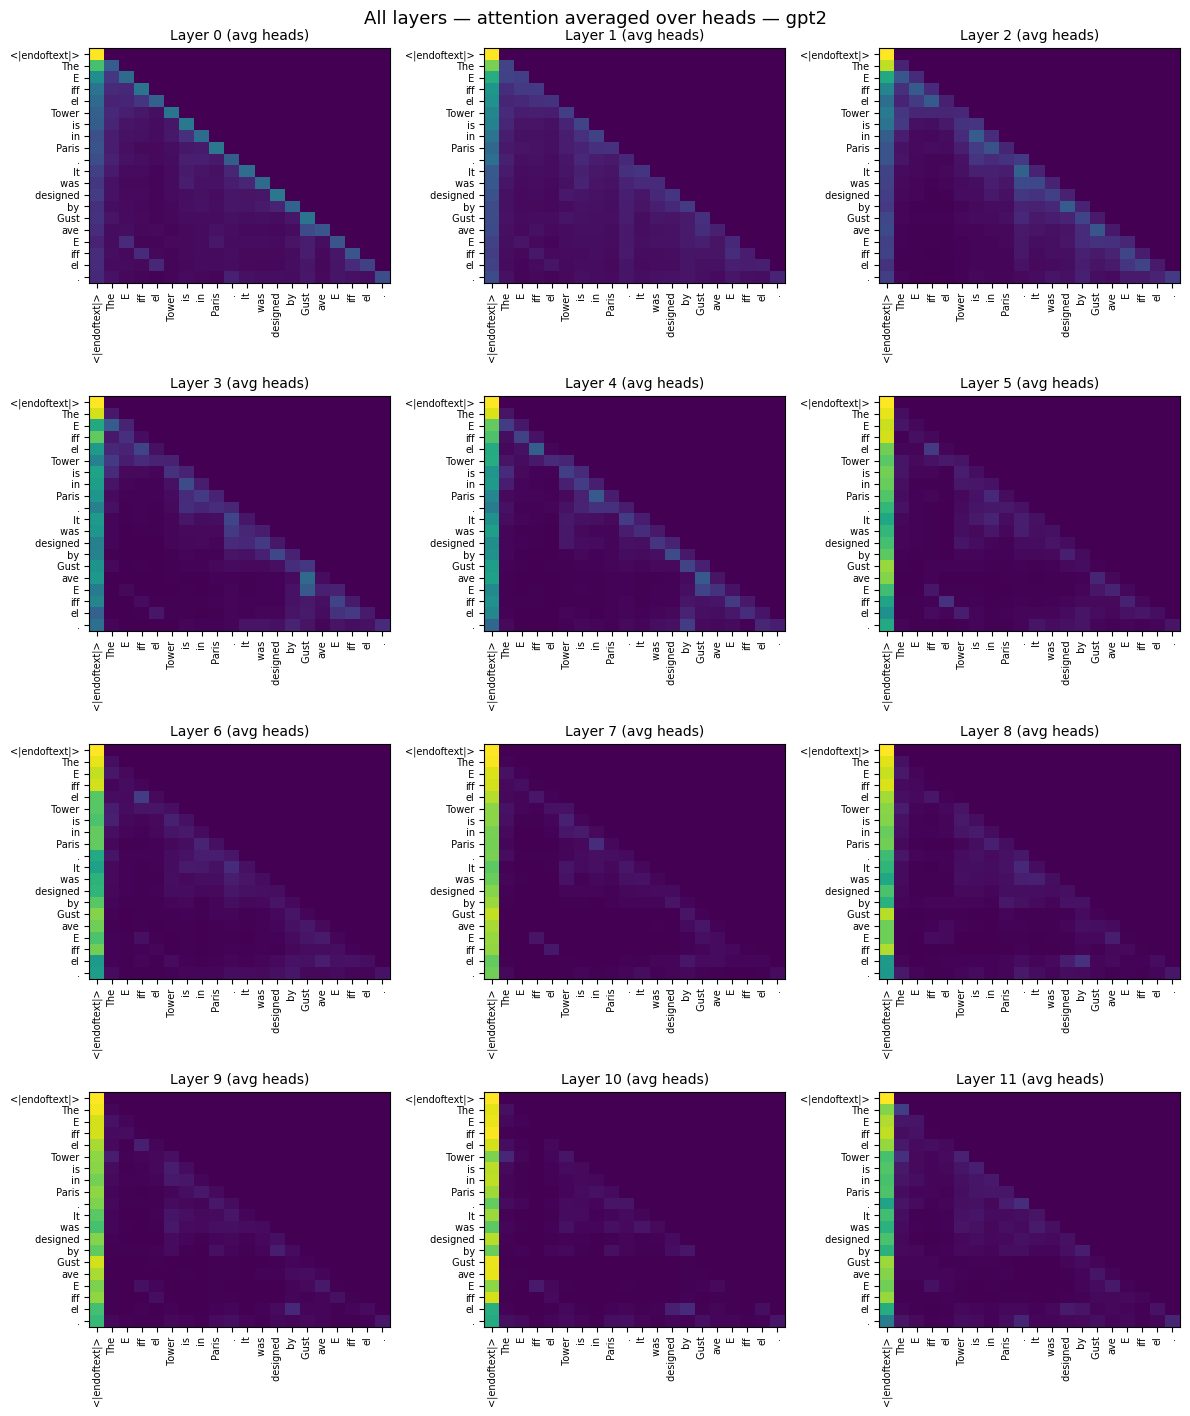

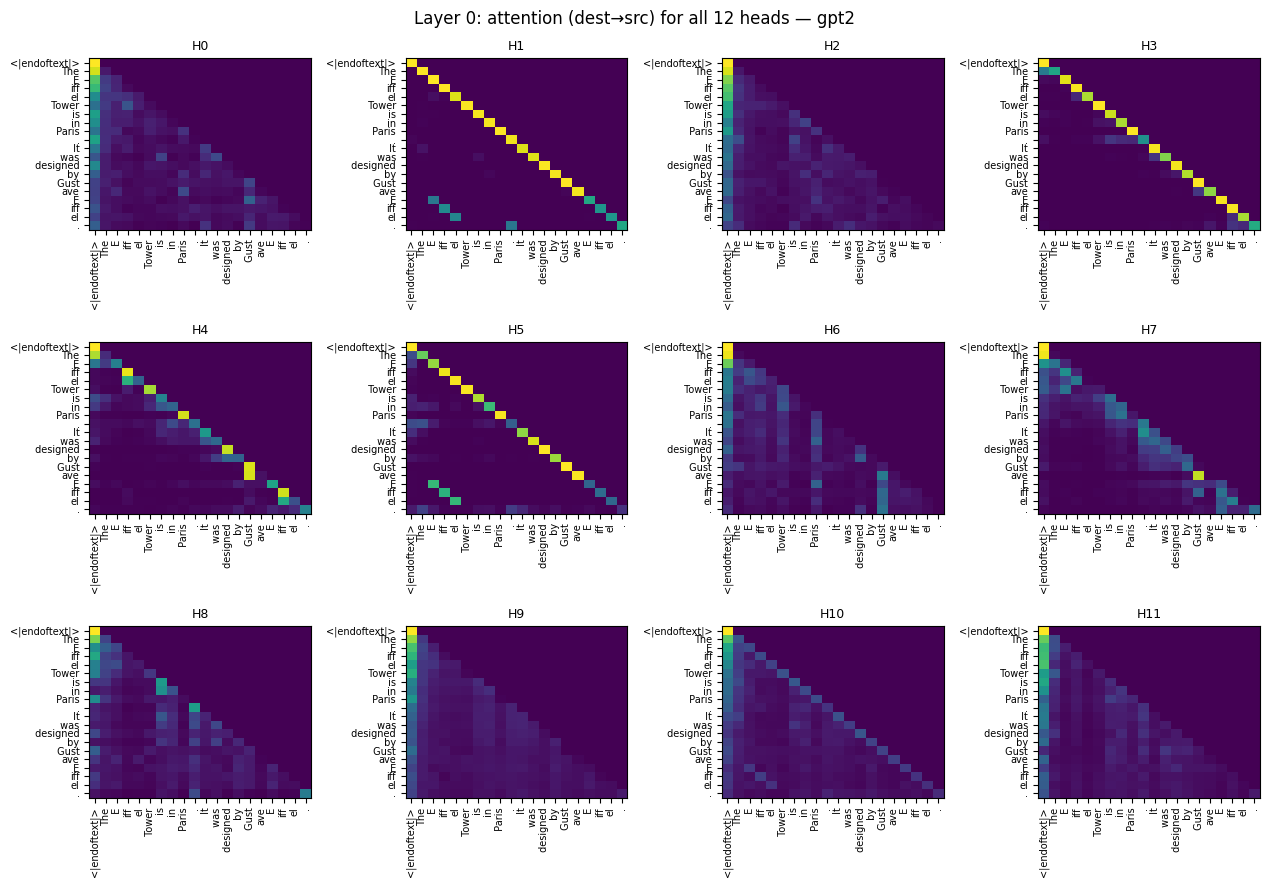

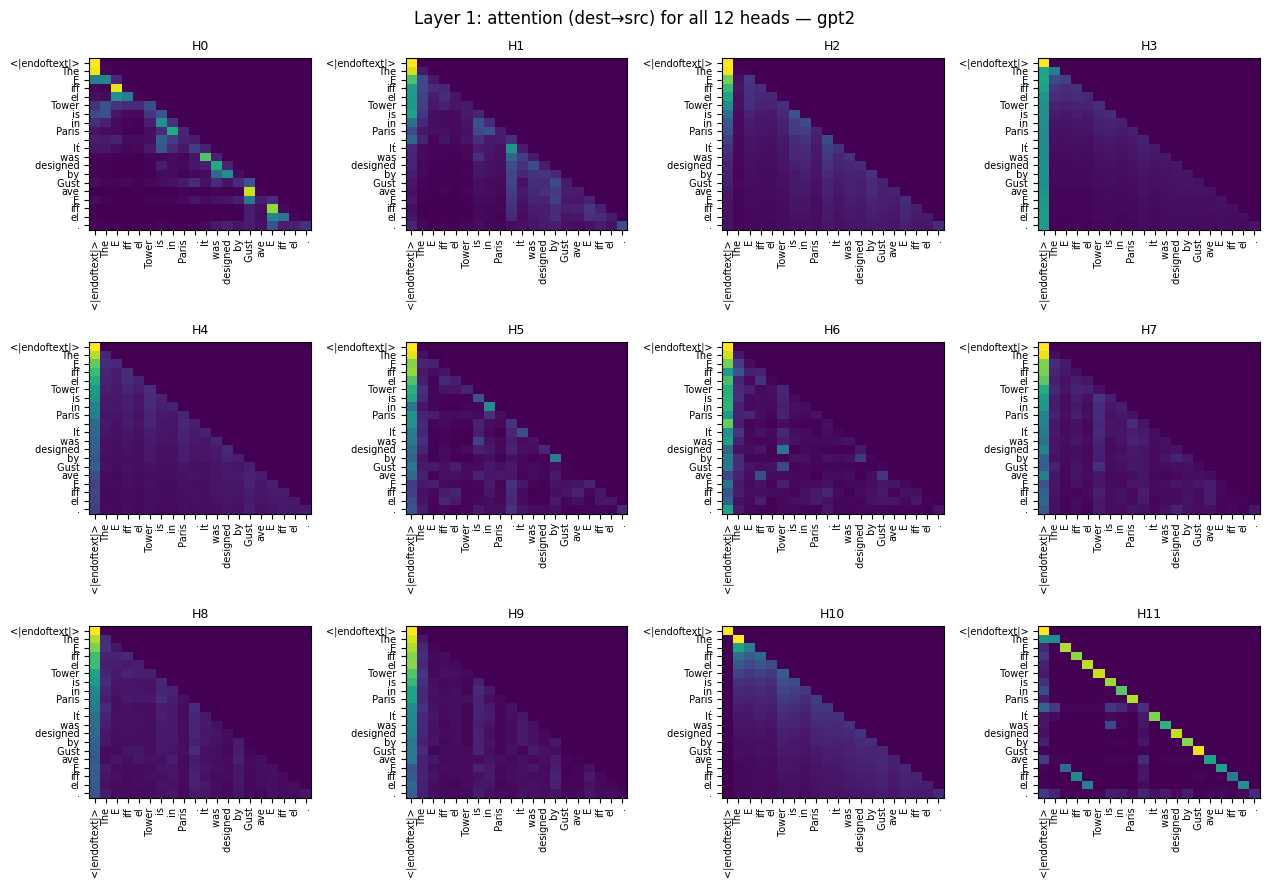

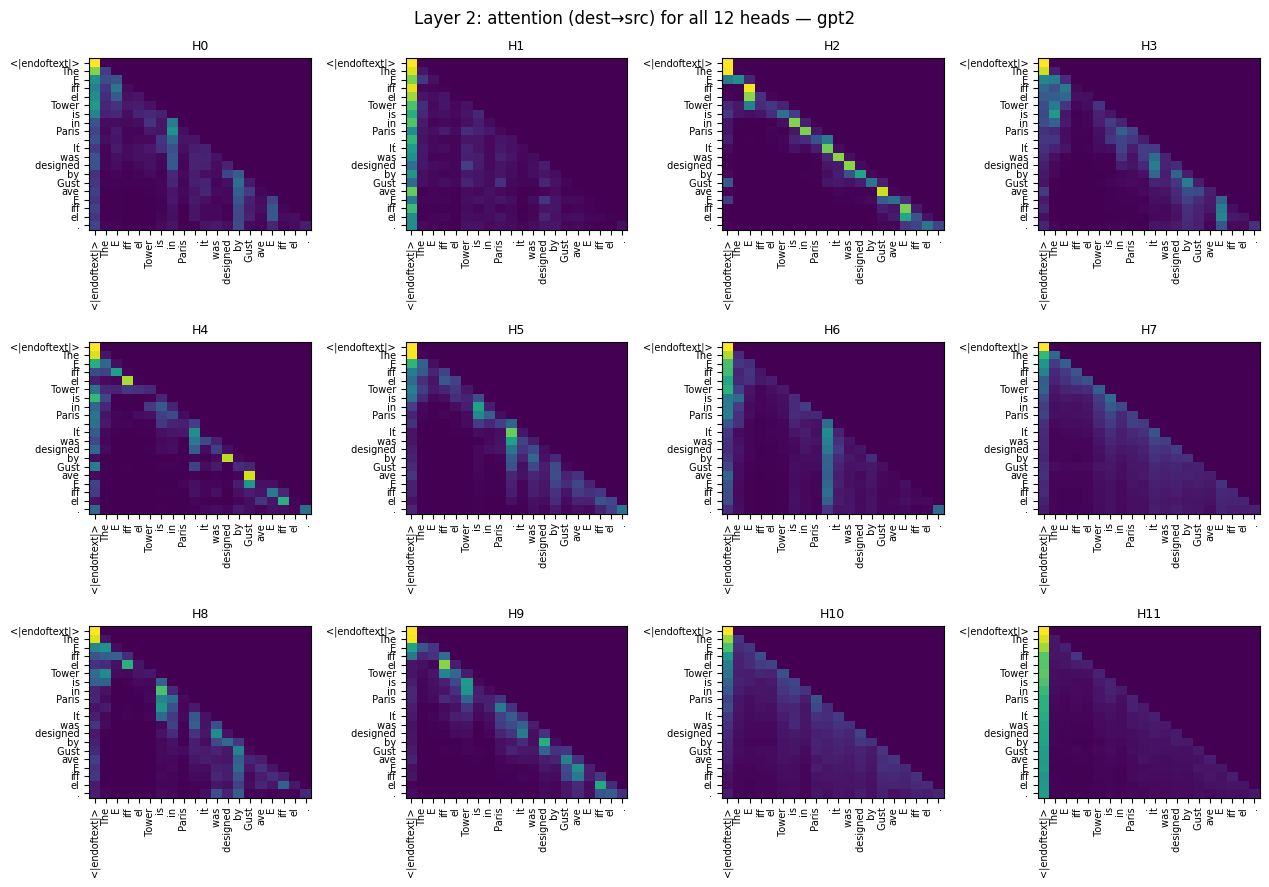

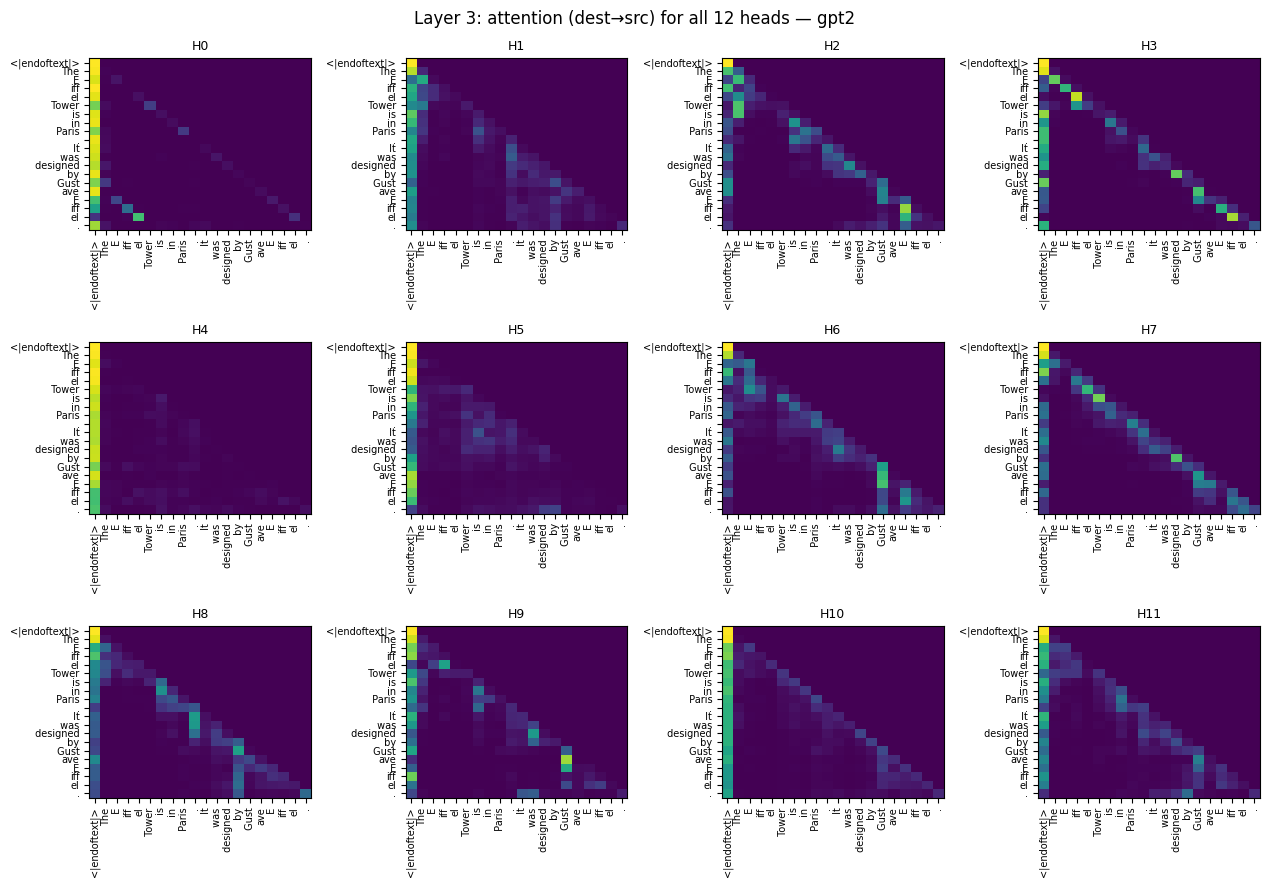

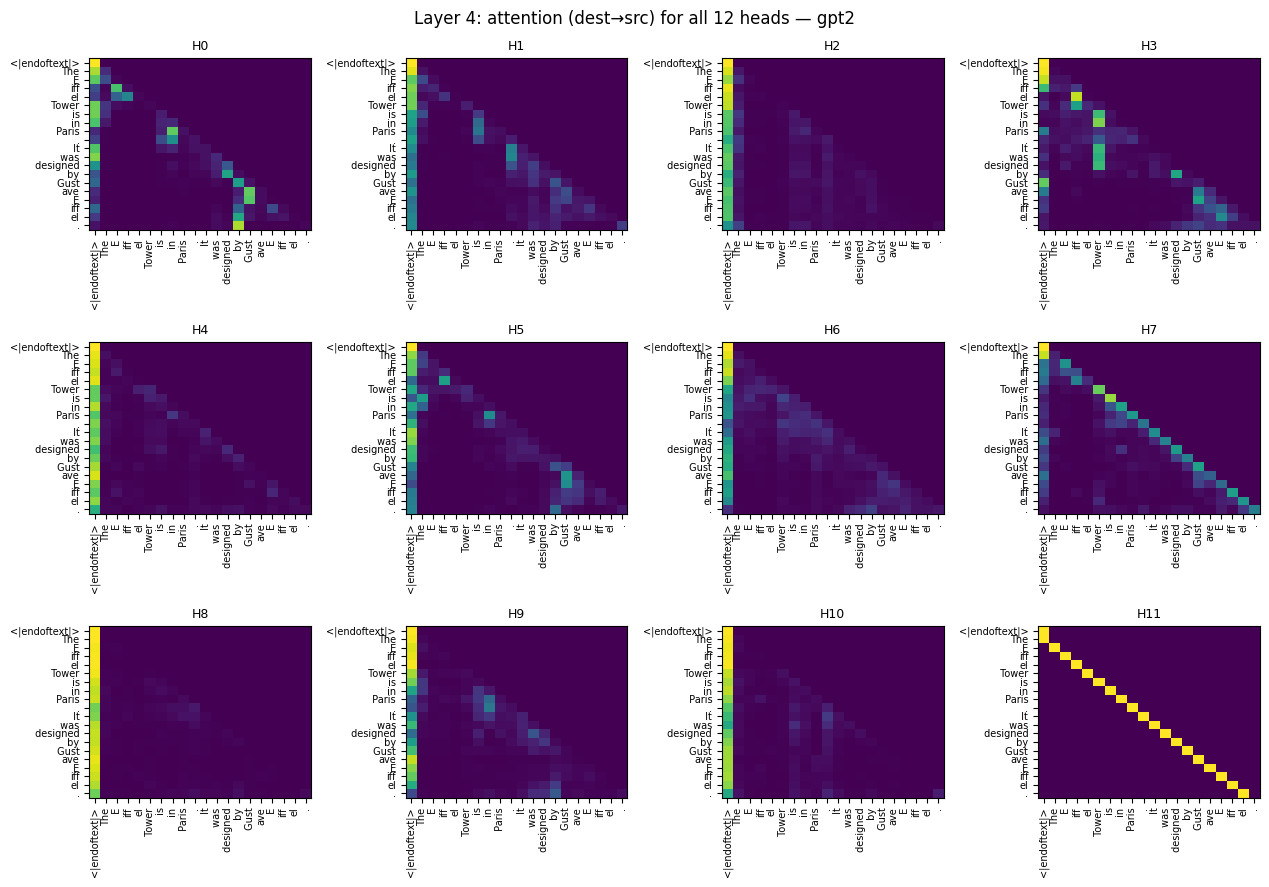

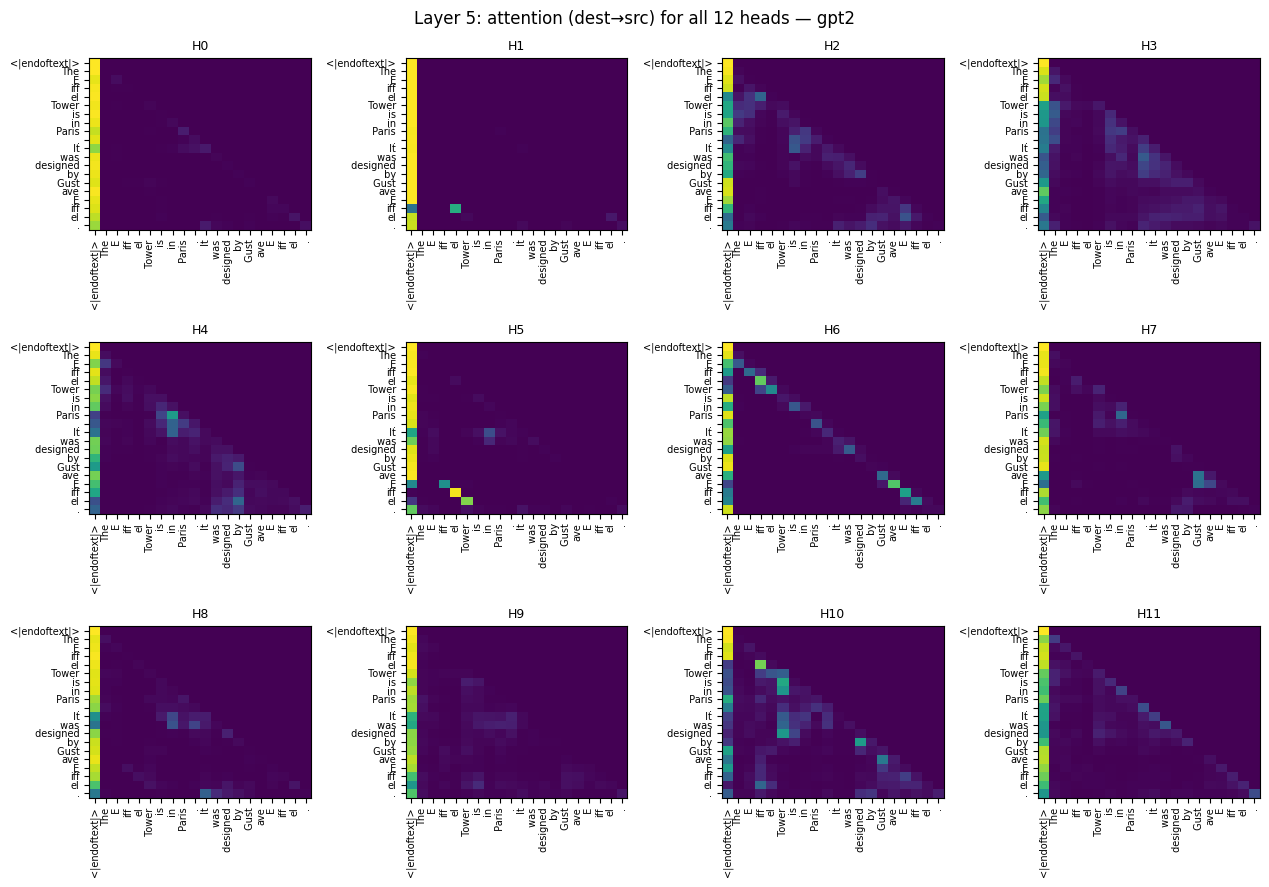

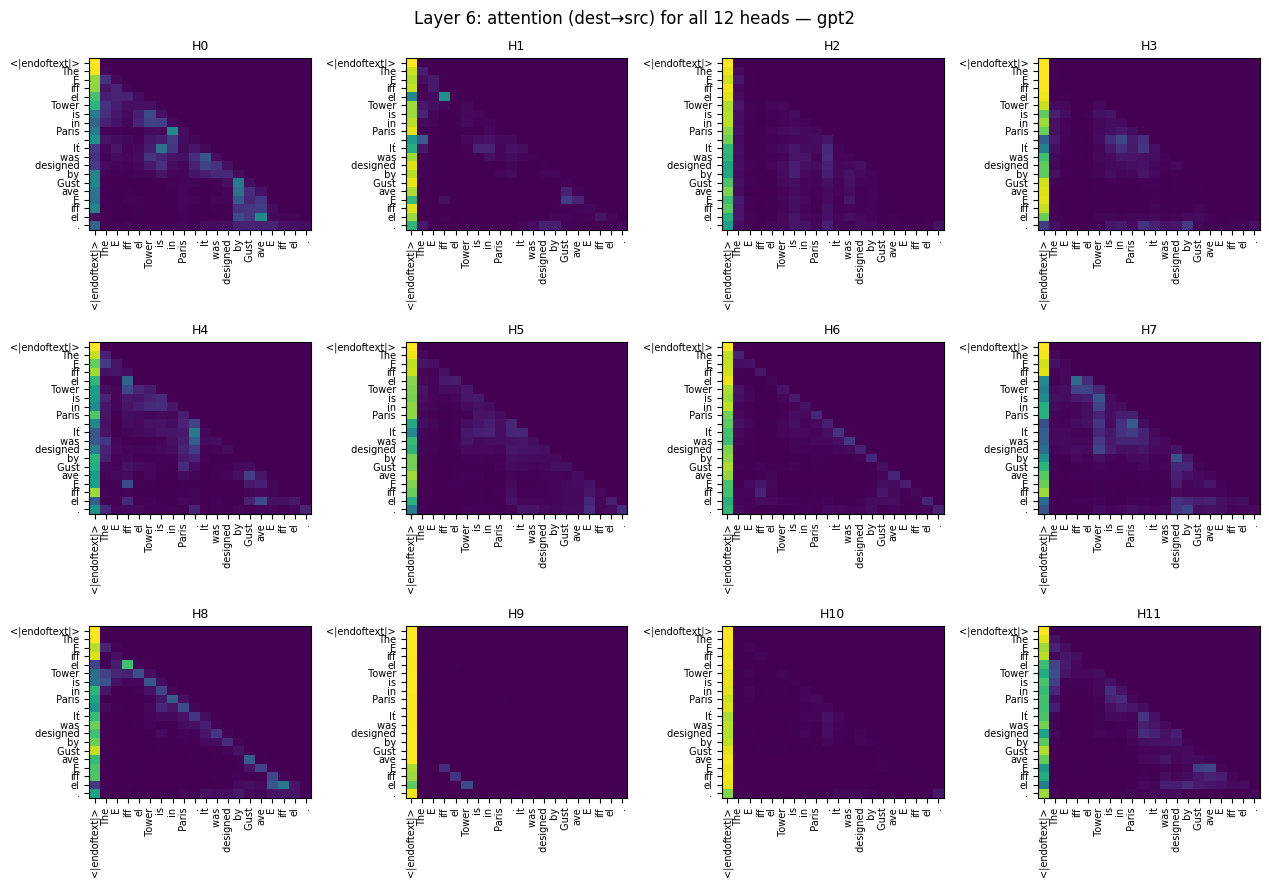

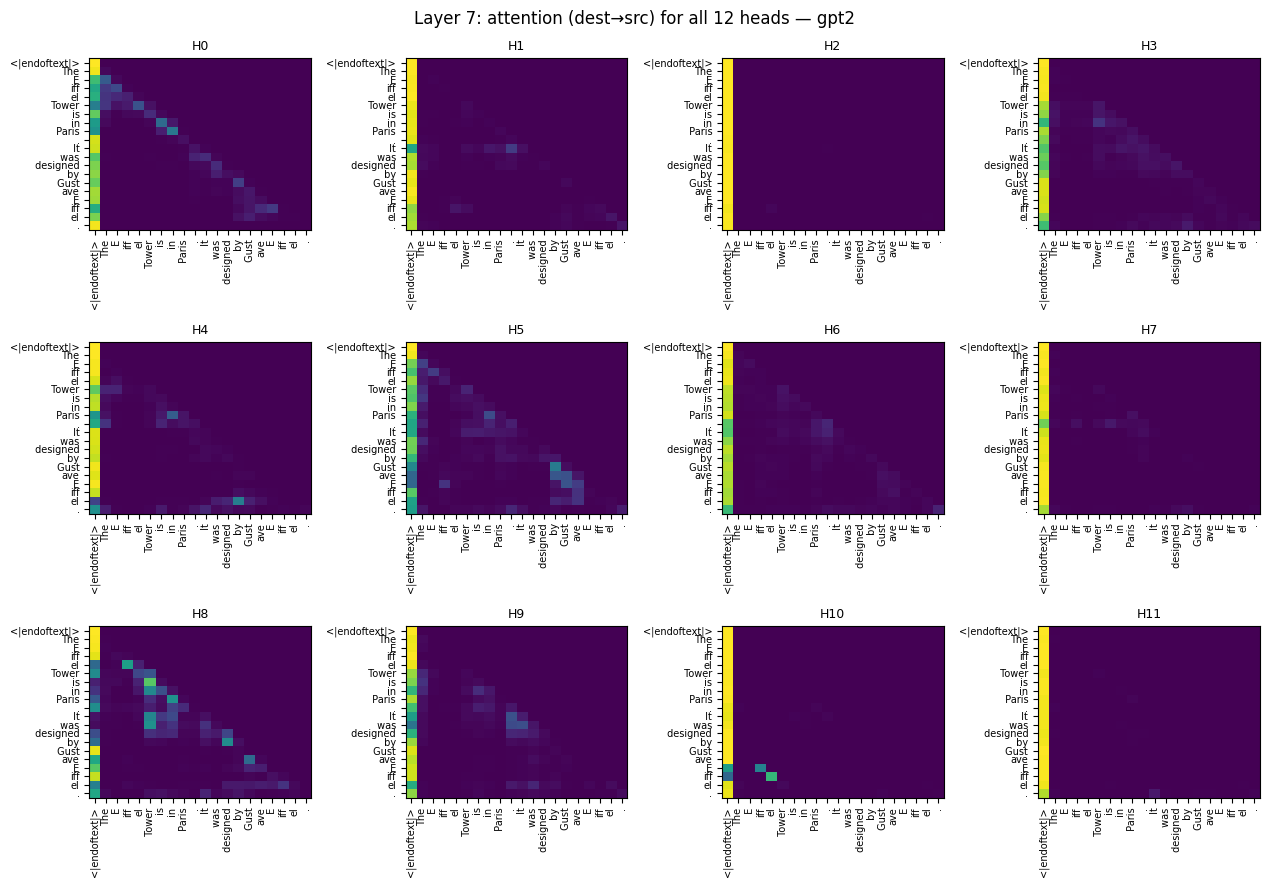

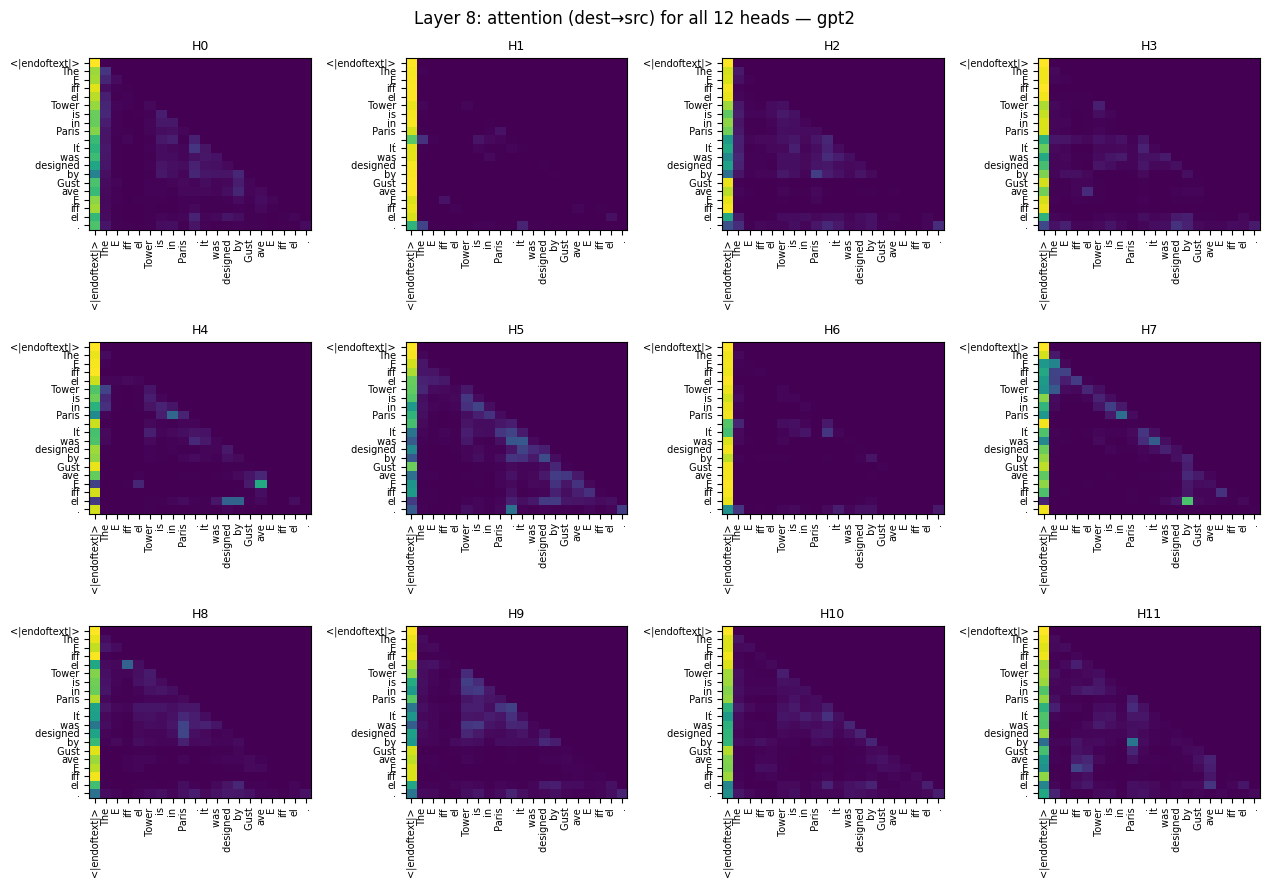

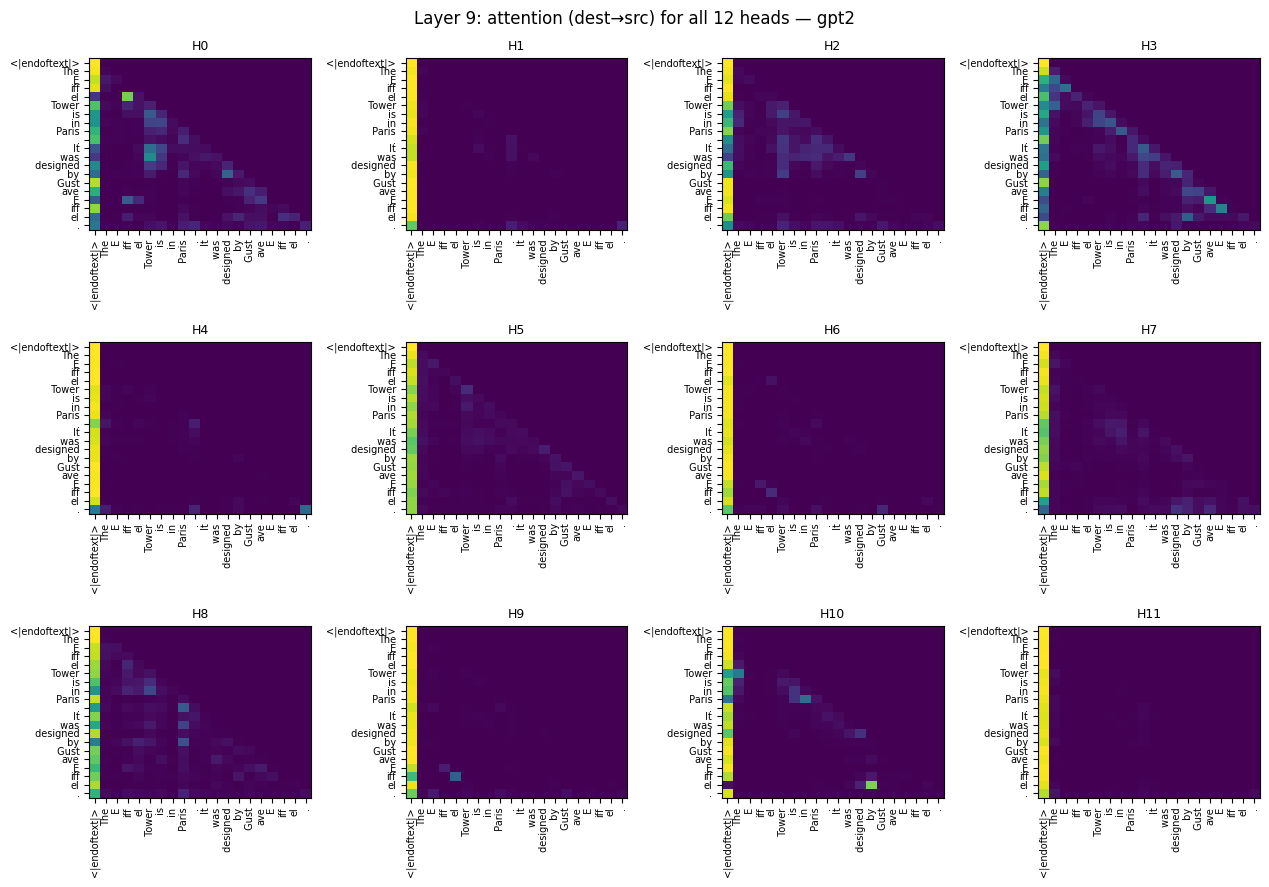

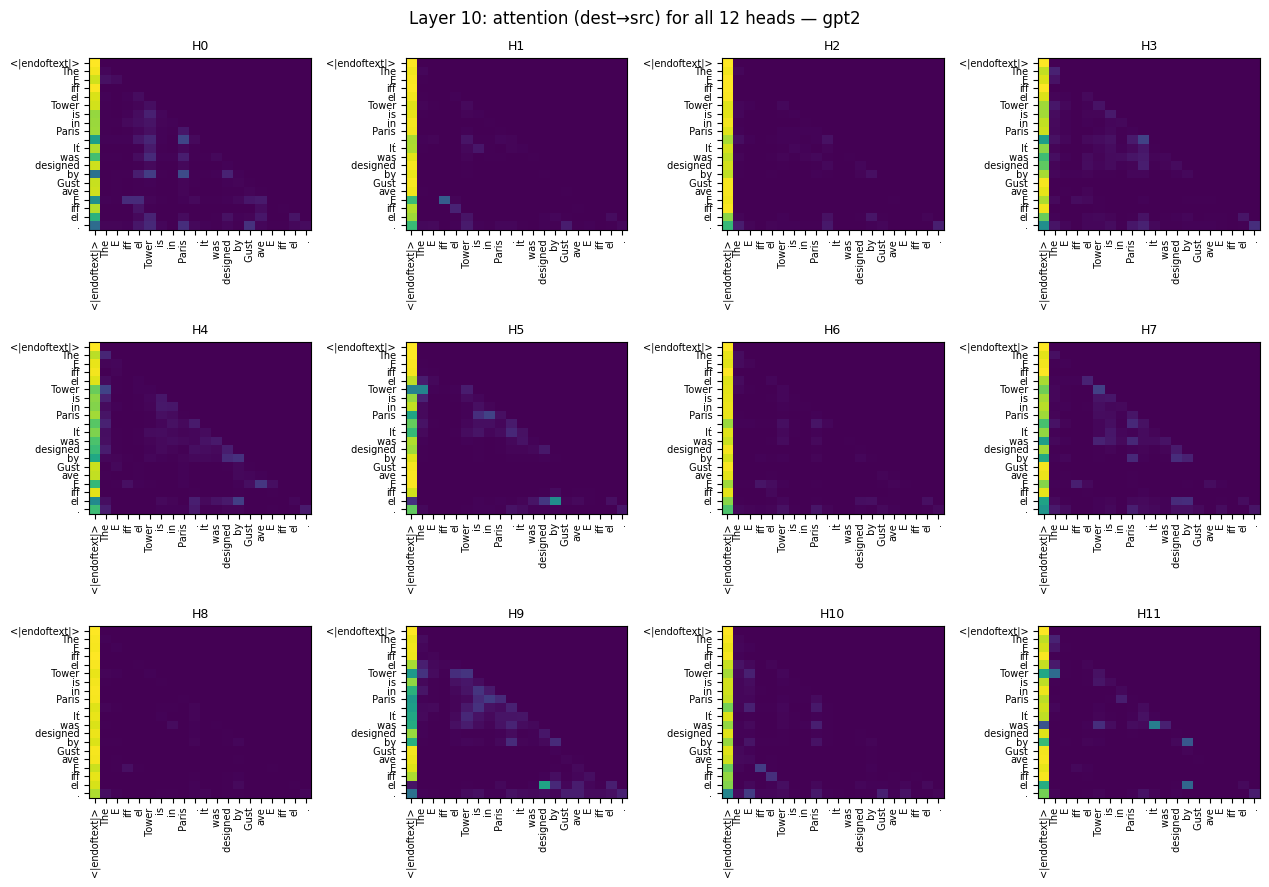

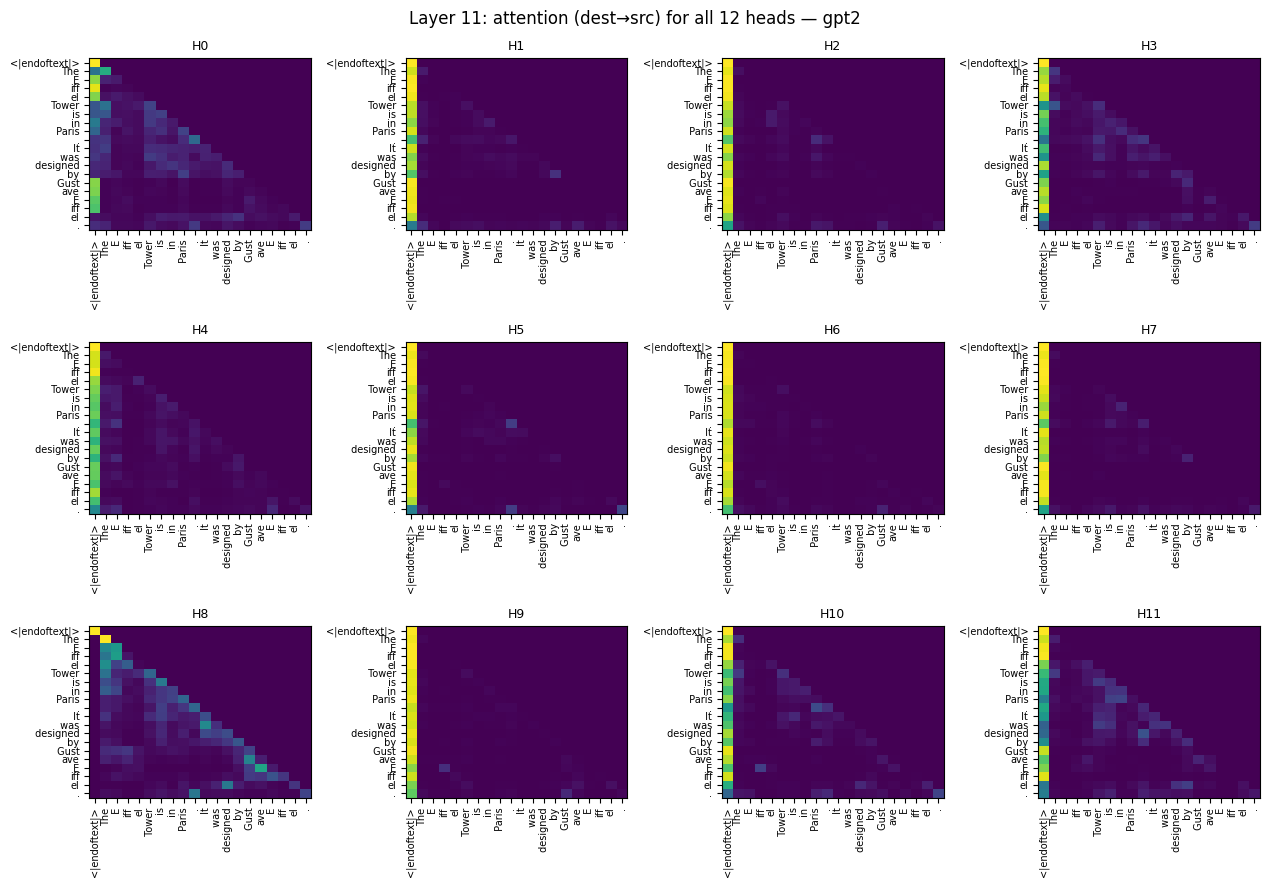

In [ ]:
# Notebook-friendly full attention viz (TransformerLens)
# pip install -U torch transformer-lens einops jaxtyping matplotlib

import os, math
from typing import List, Optional, Tuple

import torch
import numpy as np
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer

# ===================== Config (edit these) =====================
MODEL_NAME = "gpt2"  # e.g., "gpt2", "gpt2-small", "pythia-70m-deduped"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PROMPT = "The Eiffel Tower is in Paris. It was designed by Gustave Eiffel."
LAYERS = None           # e.g., [0, 5, 11] or None for all layers
SHORT_LABELS = False    # True = shorten token labels on axes
SAVE_DIR = None         # e.g., "attn_pngs" to save PNGs; None shows plots
# ===============================================================

def shorten_labels(labels: List[str], max_len: int = 12) -> List[str]:
    return [t if len(t) <= max_len else t[: max_len - 1] + "…" for t in labels]

def get_tokens(model: HookedTransformer, prompt: str) -> Tuple[torch.Tensor, List[str]]:
    toks = model.to_tokens(prompt, prepend_bos=True)
    str_toks = model.to_str_tokens(prompt, prepend_bos=True)
    return toks, str_toks

def run_with_cache(model: HookedTransformer, toks: torch.Tensor):
    with torch.no_grad():
        logits, cache = model.run_with_cache(toks)
    return logits, cache

def get_attn_pattern(cache, layer: int) -> torch.Tensor:
    # Attention probabilities (post-softmax): [batch, heads, dest_pos, src_pos]
    return cache["attn", layer]

def plot_all_layers_avg_over_heads(cache, token_labels: List[str], model: HookedTransformer,
                                   save_dir: Optional[str] = None, label: str = ""):
    L = model.cfg.n_layers
    cols = 3
    rows = math.ceil(L / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4.0, rows * 3.6))
    axes = np.array(axes).reshape(rows, cols)

    for layer in range(L):
        attn = cache["attn", layer]                # [B, H, Q, K]
        avg = attn.mean(dim=1)[0].detach().cpu().numpy()  # [Q, K]
        Q, K = avg.shape
        r, c = divmod(layer, cols)
        ax = axes[r, c]
        im = ax.imshow(avg, aspect="auto", interpolation="nearest")
        ax.set_title(f"Layer {layer} (avg heads)", fontsize=10)
        ax.set_xticks(range(K)); ax.set_xticklabels(token_labels[:K], rotation=90, fontsize=7)
        ax.set_yticks(range(Q)); ax.set_yticklabels(token_labels[:Q], fontsize=7)

    for i in range(L, rows * cols):
        r, c = divmod(i, cols)
        axes[r, c].axis("off")

    fig.suptitle(f"All layers — attention averaged over heads{label}", fontsize=13)
    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        out = os.path.join(save_dir, "all_layers_avg_over_heads.png")
        plt.savefig(out, dpi=160, bbox_inches="tight")
        plt.close(fig)
        print(f"[saved] {out}")
    else:
        plt.show()

def plot_layer_all_heads(attn: torch.Tensor, token_labels: List[str], layer: int,
                         save_dir: Optional[str] = None, label: str = ""):
    assert attn.ndim == 4 and attn.shape[0] == 1
    _, H, Q, K = attn.shape

    cols = math.ceil(math.sqrt(H))
    rows = math.ceil(H / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 3.0))
    axes = np.array(axes).reshape(rows, cols)

    for h in range(H):
        r, c = divmod(h, cols)
        ax = axes[r, c]
        data = attn[0, h].detach().cpu().numpy()
        im = ax.imshow(data, aspect="auto", interpolation="nearest")
        ax.set_title(f"H{h}", fontsize=9)
        ax.set_xticks(range(K)); ax.set_xticklabels(token_labels[:K], rotation=90, fontsize=7)
        ax.set_yticks(range(Q)); ax.set_yticklabels(token_labels[:Q], fontsize=7)

    for h in range(H, rows * cols):
        r, c = divmod(h, cols)
        axes[r, c].axis("off")

    fig.suptitle(f"Layer {layer}: attention (dest→src) for all {H} heads{label}", fontsize=12)
    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        out = os.path.join(save_dir, f"layer_{layer:02d}_all_heads.png")
        plt.savefig(out, dpi=160, bbox_inches="tight")
        plt.close(fig)
        print(f"[saved] {out}")
    else:
        plt.show()

# -------------------- Run --------------------
print(f"Loading {MODEL_NAME} on {DEVICE} ...")
model = HookedTransformer.from_pretrained(MODEL_NAME, device=DEVICE)

toks, labels = get_tokens(model, PROMPT)
if SHORT_LABELS:
    labels = shorten_labels(labels, max_len=12)

print("Running model and collecting cache ...")
logits, cache = run_with_cache(model, toks)

tag = f" — {MODEL_NAME}"
# 1) Overview: one heatmap per layer (avg over heads)
plot_all_layers_avg_over_heads(cache, labels, model, save_dir=SAVE_DIR, label=tag)

# 2) Detailed per-layer: all heads (can be many plots)
L = model.cfg.n_layers
target_layers = LAYERS if LAYERS is not None else list(range(L))

for layer in target_layers:
    attn_layer = get_attn_pattern(cache, layer)
    plot_layer_all_heads(attn_layer, labels, layer=layer, save_dir=SAVE_DIR, label=tag)


In [ ]:
# DeepSeek (Hugging Face) attention viz – notebook friendly
# pip install -U transformers accelerate torch matplotlib

import os, math
from typing import List, Optional, Tuple

import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer

# ===================== Config (edit these) =====================
MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PROMPT = "The Eiffel Tower is in Paris. It was designed by Gustave Eiffel."
LAYERS = None           # e.g., [0, 5, 11] or None for all layers
SHORT_LABELS = False    # True = shorten token labels on axes
SAVE_DIR = None         # e.g., "attn_pngs" to save PNGs; None shows plots
MAX_LEN = 128           # truncate long prompts if needed
# ===============================================================

def shorten_labels(labels: List[str], max_len: int = 12) -> List[str]:
    return [t if len(t) <= max_len else t[: max_len - 1] + "…" for t in labels]

# ---------- Load model & tokenizer ----------
print(f"Loading {MODEL_NAME} on {DEVICE} ...")
tok = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
    device_map="auto" if DEVICE == "cuda" else None,
    trust_remote_code=True,
)
model.to(DEVICE)
model.eval()

# ---------- Tokenize ----------
enc = tok(PROMPT, return_tensors="pt", add_special_tokens=True)
for k in enc: enc[k] = enc[k][:, :MAX_LEN]
enc = {k: v.to(DEVICE) for k, v in enc.items()}
str_tokens = tok.convert_ids_to_tokens(enc["input_ids"][0].tolist())

if SHORT_LABELS:
    str_tokens = shorten_labels(str_tokens, 12)

# ---------- Forward pass with attention ----------
# Important: use output_attentions=True
with torch.no_grad():
    out = model(**enc, output_attentions=True, use_cache=False)

# out.attentions is a tuple length = num_layers
# each item: [batch, heads, dest_pos, src_pos]
attns = out.attentions
num_layers = len(attns)
batch, num_heads, qlen, klen = attns[0].shape
assert batch == 1, "This snippet assumes batch size 1."

# ---------- Plotting helpers ----------
def plot_all_layers_avg_over_heads(attns, token_labels, save_dir: Optional[str] = None, label: str = ""):
    L = len(attns)
    cols = 3
    rows = math.ceil(L / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4.0, rows * 3.6))
    axes = np.array(axes).reshape(rows, cols)

    Q = K = None
    for layer, patt in enumerate(attns):
        avg = patt.mean(dim=1)[0].detach().float().cpu().numpy()  # [Q, K]
        if Q is None:
            Q, K = avg.shape
        r, c = divmod(layer, cols)
        ax = axes[r, c]
        im = ax.imshow(avg, aspect="auto", interpolation="nearest")
        ax.set_title(f"Layer {layer} (avg heads)", fontsize=10)
        ax.set_xticks(range(K)); ax.set_xticklabels(token_labels[:K], rotation=90, fontsize=7)
        ax.set_yticks(range(Q)); ax.set_yticklabels(token_labels[:Q], fontsize=7)

    for i in range(L, rows * cols):
        r, c = divmod(i, cols); axes[r, c].axis("off")

    fig.suptitle(f"All layers — attention averaged over heads{label}", fontsize=13)
    plt.tight_layout()
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        out_path = os.path.join(save_dir, "all_layers_avg_over_heads.png")
        plt.savefig(out_path, dpi=160, bbox_inches="tight"); plt.close(fig)
        print(f"[saved] {out_path}")
    else:
        plt.show()

def plot_layer_all_heads(patt: torch.Tensor, token_labels, layer: int, save_dir: Optional[str] = None, label: str = ""):
    assert patt.ndim == 4 and patt.shape[0] == 1
    _, H, Q, K = patt.shape
    cols = math.ceil(math.sqrt(H)); rows = math.ceil(H / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 3.0))
    axes = np.array(axes).reshape(rows, cols)

    for h in range(H):
        r, c = divmod(h, cols)
        ax = axes[r, c]
        data = patt[0, h].detach().float().cpu().numpy()
        ax.imshow(data, aspect="auto", interpolation="nearest")
        ax.set_title(f"H{h}", fontsize=9)
        ax.set_xticks(range(K)); ax.set_xticklabels(token_labels[:K], rotation=90, fontsize=7)
        ax.set_yticks(range(Q)); ax.set_yticklabels(token_labels[:Q], fontsize=7)

    for h in range(H, rows * cols):
        r, c = divmod(h, cols); axes[r, c].axis("off")

    fig.suptitle(f"Layer {layer}: attention (dest→src) for all {H} heads{label}", fontsize=12)
    plt.tight_layout()
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        out_path = os.path.join(save_dir, f"layer_{layer:02d}_all_heads.png")
        plt.savefig(out_path, dpi=160, bbox_inches="tight"); plt.close(fig)
        print(f"[saved] {out_path}")
    else:
        plt.show()

# ---------- Draw ----------
tag = f" — {MODEL_NAME}"
plot_all_layers_avg_over_heads(attns, str_tokens, save_dir=SAVE_DIR, label=tag)

target_layers = LAYERS if LAYERS is not None else list(range(num_layers))
for layer in target_layers:
    plot_layer_all_heads(attns[layer], str_tokens, layer=layer, save_dir=SAVE_DIR, label=tag)


0.032768

In [ ]:
13*(4+4+2)


130

In [1]:
BS=16*10e6


BS * 13e9 /2/ 3



3.466666666666667e+17

In [ ]:


def _apply_rotary_emb(
    x: torch.Tensor,
    cos: torch.Tensor,
    sin: torch.Tensor,
) -> torch.Tensor:
    first_half, second_half = torch.chunk(x, 2, dim=-1)
    first_ = first_half * cos - second_half * sin
    second_ = second_half * cos + first_half * sin
    return torch.cat((first_, second_), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = _apply_rotary_emb(q, cos, sin)
    k_embed = _apply_rotary_emb(k, cos, sin)
    return q_embed, k_embed





In [ ]:
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin, ):
    """Apply rotary position embedding to query and key tensors"""
    
    cos = cos[:q.shape[1], :]  # [seq_len, head_dim]
    sin = sin[:q.shape[1], :]  # [seq_len, head_dim]
  
    
    # Add head dimension for broadcasting
    cos = cos.unsqueeze(-2)  # [seq_len, 1, head_dim] or [batch, seq_len, 1, head_dim]
    sin = sin.unsqueeze(-2)  # [seq_len, 1, head_dim] or [batch, seq_len, 1, head_dim]
    
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)

    
    return q_embed, k_embed

# Precompute cos and sin
def precompute_rope_embeddings(head_dim, max_seq_len, theta=10000.0):
    inv_freq = 1.0 / (theta ** (torch.arange(0, head_dim, 2).float() / head_dim))
    t = torch.arange(max_seq_len).float()
    freqs = torch.outer(t, inv_freq)  # [seq_len, head_dim//2]
    emb = torch.cat((freqs, freqs), dim=-1)  # [seq_len, head_dim]
    cos = emb.cos()
    sin = emb.sin()
    return cos, sin

# Usage
head_dim = 64
max_seq_len = 2048
cos, sin = precompute_rope_embeddings(head_dim, max_seq_len)


# Sample tensors
q = torch.randn(2, 128, 8, 64)  # [batch, seq_len, n_heads, head_dim]
k = torch.randn(2, 128, 8, 64)

# Apply RoPE
q_rope, k_rope = apply_rotary_pos_emb(q, k, cos, sin)

tensor([[[[ 2.9631e-01,  1.0836e+00,  5.7108e-01,  ...,  1.5422e+00,
            1.0046e+00,  1.9510e+00],
          [ 5.6145e-01,  8.4329e-01, -3.9682e-01,  ..., -3.7833e-01,
           -1.1792e-01,  1.2360e+00],
          [ 1.8128e+00, -6.4013e-01, -1.3713e-02,  ...,  1.0021e+00,
           -1.4177e+00, -2.2861e+00],
          ...,
          [ 7.7529e-02, -7.4532e-01, -6.9815e-01,  ...,  9.1766e-01,
           -6.9837e-01,  1.2471e+00],
          [ 1.7660e+00, -9.4374e-01,  6.2386e-01,  ..., -9.9895e-01,
           -5.4891e-01, -1.9840e-01],
          [ 1.5296e+00, -1.4970e+00,  2.2809e+00,  ...,  2.1999e+00,
           -4.9919e-01,  8.4773e-01]],

         [[-8.3223e-01,  8.6246e-01,  1.2151e+00,  ...,  4.3963e-01,
           -4.5308e-01,  1.0237e+00],
          [-1.5865e+00,  5.6978e-01, -1.2565e-01,  ...,  2.4414e+00,
            2.5524e-01,  7.8171e-01],
          [-2.5127e-01, -1.6005e+00, -7.1479e-01,  ...,  1.7589e+00,
           -4.7050e-01,  6.2093e-02],
          ...,
     

In [23]:
cos[100]

tensor([ 0.8623,  0.9176,  0.9509, -0.2395,  0.9787,  0.1512,  0.4830,  0.7187,
        -0.8391,  0.3476,  0.7901, -0.4754, -0.9998, -0.7178, -0.2060,  0.2351,
         0.5403,  0.7318,  0.8460,  0.9124,  0.9504,  0.9720,  0.9842,  0.9911,
         0.9950,  0.9972,  0.9984,  0.9991,  0.9995,  0.9997,  0.9998,  0.9999,
         0.8623,  0.9176,  0.9509, -0.2395,  0.9787,  0.1512,  0.4830,  0.7187,
        -0.8391,  0.3476,  0.7901, -0.4754, -0.9998, -0.7178, -0.2060,  0.2351,
         0.5403,  0.7318,  0.8460,  0.9124,  0.9504,  0.9720,  0.9842,  0.9911,
         0.9950,  0.9972,  0.9984,  0.9991,  0.9995,  0.9997,  0.9998,  0.9999])

In [ ]:
x = torch.randn(10)

torch.cos(torch.arange(10).unsqueeze(0))


tensor([[ 0.9943,  0.9921, -0.9944, -1.4065, -1.0709, -0.9304, -0.3344,  1.7639,
         -1.0196, -0.6714]])

In [52]:
import torch
import torch.nn as nn
import pandas as pd


d_model = 6000

residual = torch.rand(10000, d_model, requires_grad=False) #seq_len, head_dim


class Model(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.MLA_down = nn.Linear(d_model,kwargs.get("compression", 32))
        self.MLA_up = nn.Linear(kwargs.get("compression", 32),d_model)


    def forward(self,x):
        return self.MLA_up(self.MLA_down(x))







losses = {}

for comp in [2**x for x in range(8)]:
    model = Model(compression=comp)
    optimizer = torch.optim.Adam(model.parameters())
    
    for _ in range(100):
        output = model(residual)
        loss = torch.square(residual  - output).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
    losses[comp] = loss.item()




<Axes: >

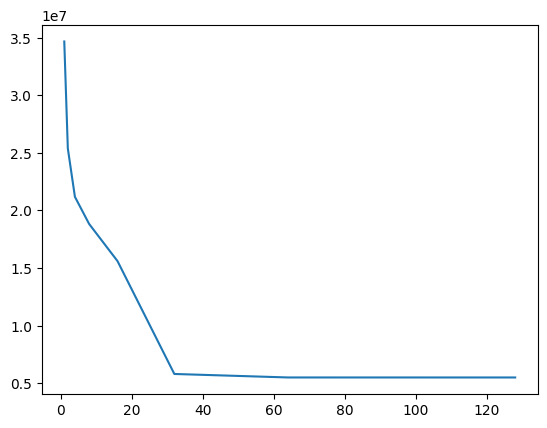

In [53]:
df = pd.Series(losses)
df.plot.line()

In [93]:
#Block latent attention

residual  = torch.randn(109,724)
zero_vector = torch.zeros(1,724)

block_size = 8

num_zero_vectors = block_size - residual.size()[0] % block_size
stacked_tensor = zero_vector.repeat(num_zero_vectors,1)

output = torch.cat([residual, stacked_tensor])
blocks = output.view(-1, block_size *724)

class Model(nn.Module):
    def __init__(self, in_dim, compression) -> None:
        super().__init__()
        self.MLA_down = nn.Linear(in_dim,compression)
        self.MLA_up = nn.Linear(compression,in_dim)


    def forward(self,x):
        return self.MLA_up(self.MLA_down(x))

    def compress(self,x):
        return self.MLA_down(x)

model = Model(block_size *724, compression = 32)

model.compress(blocks)

tensor([[ 8.9169e-01, -8.6644e-01,  2.5523e-01,  1.0207e+00, -7.1341e-01,
         -2.8721e-01,  8.1029e-01, -5.6195e-01, -4.6703e-01, -9.5409e-03,
         -6.0065e-01,  3.2407e-01, -3.2367e-02, -2.0290e-01,  3.3200e-01,
          4.0129e-01, -5.1854e-02, -5.0900e-01, -4.7181e-01, -1.3461e-01,
         -2.9092e-01,  4.5043e-02,  4.8068e-01,  3.6402e-01,  6.4178e-02,
          6.1919e-01, -3.7041e-01, -7.7917e-01, -9.9378e-02, -1.0909e+00,
         -3.3623e-01, -3.4796e-01],
        [-4.6286e-01, -1.3225e+00,  3.6253e-01,  4.7937e-01,  2.5283e-01,
          1.9458e-01, -2.0001e-01, -1.7746e-01,  6.5317e-01,  8.1550e-01,
         -6.8275e-01,  1.7123e-01,  3.0629e-01,  3.4938e-01, -1.0618e+00,
         -4.1685e-01, -2.4417e-02,  1.6481e-02,  1.1027e+00,  1.7403e-01,
          1.4787e-01,  1.1684e+00,  2.6750e-01, -1.9253e-02, -2.1547e-01,
         -8.0986e-01,  7.3957e-01, -5.4031e-01,  3.3533e-01,  3.0993e-01,
          2.5285e-01,  5.2860e-01],
        [ 1.2357e-01,  1.9198e-01,  2.86

In [106]:
Q = torch.randn(32, 8, 60, 64)                 # (b,h,t,d)
K = torch.randn(32, 8, 60, 64)                 # (b,h,s,d)

torch.einsum("bhtd,bhsd->bhts",Q,K)


tensor([[[[-1.4315e+01, -1.5860e+01, -3.3445e+00,  ..., -1.2841e+01,
           -6.2740e-01,  5.3147e+00],
          [-6.7532e-01,  9.0053e+00,  1.0784e+01,  ..., -1.1139e+01,
           -5.2543e+00, -5.4607e+00],
          [-9.8746e-01,  6.5747e+00, -8.3416e+00,  ...,  3.3787e-02,
           -5.4612e+00, -2.7988e+00],
          ...,
          [-7.5131e+00,  7.1209e-01,  2.3132e-01,  ...,  2.0686e+00,
           -3.5595e+00, -5.9692e+00],
          [ 1.5604e+00, -8.4021e+00, -1.4603e+01,  ..., -1.7819e+00,
           -7.7048e+00,  3.2025e+00],
          [ 8.3816e+00,  4.6936e+00, -5.3860e+00,  ..., -2.5359e+00,
            2.3025e+00,  1.6023e+01]],

         [[-1.0432e+01,  1.6805e+01, -1.1761e+00,  ...,  8.6958e+00,
            1.3155e+01, -1.7439e+00],
          [ 6.2589e+00,  1.0892e+00, -3.6292e+00,  ..., -1.7438e+00,
            4.9116e+00,  9.2133e+00],
          [ 6.8239e+00, -1.0257e+01, -1.1697e+01,  ..., -1.5502e+00,
            4.2262e+00, -3.2282e+00],
          ...,
     